In [1]:
#import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install arch -q
import arch as arc

In [2]:
#get S+P file
data = pd.read_csv('S&P500.csv')
all_data = pd.read_csv('Index2018.csv')
#set index
data.set_index('date', inplace=True)
all_data.date = pd.to_datetime(all_data.date, dayfirst=True)
all_data.set_index('date', inplace=True)

In [3]:
#split for train and test data using iloc
size = round(len(data)*.8)
print('Train size:', size, ' Test size:', len(data)-size)
train = data.iloc[:size]
test = data.iloc[size:]

Train size: 5022  Test size: 1255


In [4]:
train.tail()

,market_value
date,
2013-04-02,1570.252238
2013-04-03,1553.686978
2013-04-04,1559.979316
2013-04-05,1553.278930
2013-04-08,1563.071269


In [5]:
test.head()

,market_value
date,
2013-04-09,1568.607909
2013-04-10,1587.731827
2013-04-11,1593.369863
2013-04-12,1588.854623
2013-04-15,1552.363572


There are no intersections between the train and test data sets. We did an 80/20 split and checked that they are isolated. Next we learn about time series

**White Noise** conditions:
- Constant mean
- Constant variance
- No autocorrelation

In [6]:
#generate white noise series
wn = np.random.normal(loc=data.market_value.mean(), scale=data.market_value.std(), size=len(data))

In [7]:
data['wn'] = wn

In [8]:
data.describe()

,market_value,wn
count,6277.000000,6277.000000
mean,1288.642547,1289.117223
std,487.868210,493.495756
min,438.920000,-593.395671
25%,992.715221,957.578148
50%,1233.761241,1286.428216
75%,1460.250000,1620.934055
max,2872.867839,3228.010138


<function matplotlib.pyplot.show(*args, **kw)>

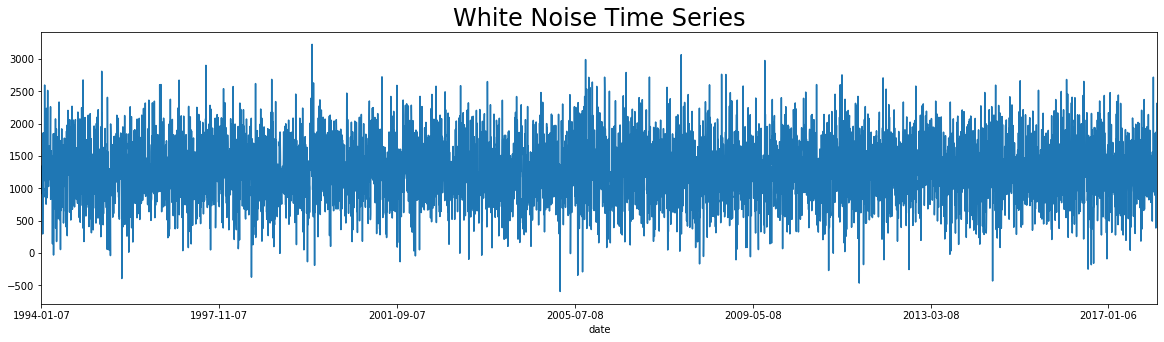

In [9]:
#plot white noise
data.wn.plot(figsize=(20,5))
plt.title('White Noise Time Series', size=24)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

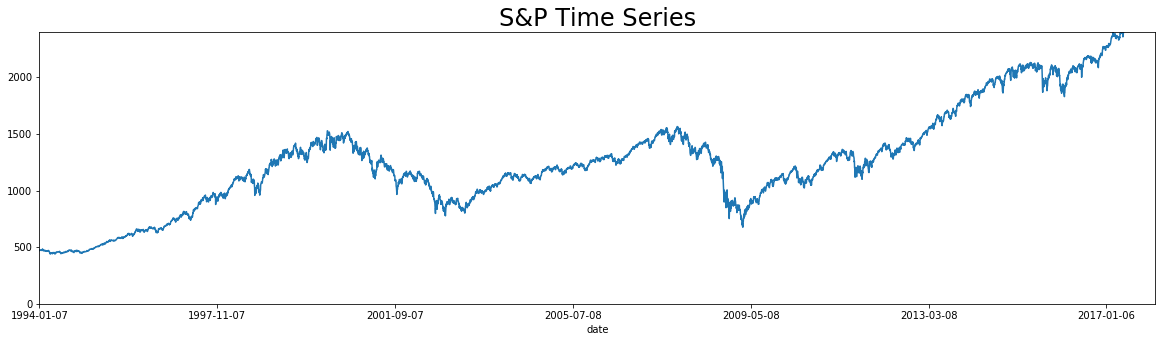

In [10]:
data.market_value.plot(figsize=(20,5))
plt.title('S&P Time Series', size=24)
plt.ylim(0,2400)
plt.show

**Random Walk** Time series where values persist over time and the differences between time periods are simply white noise. 
- RandWalk.csv file is data example of a random walk time series
We are going to plot this against the s+p to compare the two visually

In [11]:
rando = pd.read_csv('randwalk.csv')
#transform date and make it the index
rando.date = pd.to_datetime(rando.date, dayfirst=True)
rando.set_index('date', inplace=True)
rando = rando.asfreq('b')
rando.head()

,price
date,
1994-01-07,1122.139662
1994-01-10,1080.347860
1994-01-11,1082.095245
1994-01-12,1083.639265
1994-01-13,1067.146255


In [12]:
#append this column to the market value dataset
data1 = data.iloc[:len(rando)]
#had to only use a portion for demo because the randwalk doesnt have data beyond 2013
data1['rw'] = rando.price

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [13]:
data1.head()

,market_value,wn,rw
date,,,
1994-01-07,469.90,1343.455568,1122.139662
1994-01-10,475.27,975.989225,1080.347860
1994-01-11,474.13,919.627042,1082.095245
1994-01-12,474.17,1335.230903,1083.639265
1994-01-13,472.47,1122.595395,1067.146255


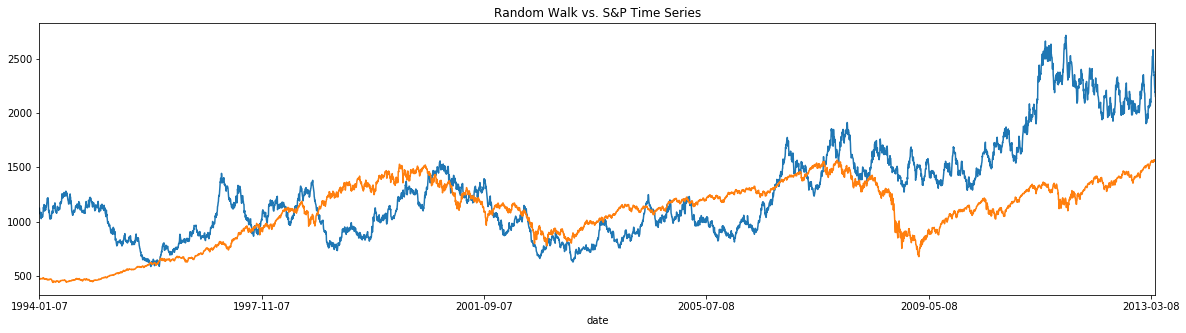

In [14]:
#randmo walk plot
data1.rw.plot(figsize=(20,5))
data1.market_value.plot()
plt.title('Random Walk vs. S&P Time Series')
plt.show()

**Market Efficiency** is a finance term defining the measure of the level of difficulty in forecasting correct future values

**Stationarity** state that implies two consecutive sets of data series will have the same covariance regardless of the starting point of the data. This is aka weak form or covariance stationarity

Three assumptions for covariance stationarity
- Constant mean
- Constant variance
- Consistent covariance between the same intervals of data

**Strict stationarity:** samples of identical size should have the same distribution i.e. both samples have the same mean and variance. This is more rare so we usually stick with the weak form/covariance stationarity when analysing data.

In [15]:
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt

In [16]:
#augmented dickey fuller unit root test
sts.adfuller(data1.market_value)
# if t< critical value, we can reject null of nonstationarity => series came from a stationary process

(-1.7369847452352445,
 0.4121645696770618,
 18,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 39904.880607487445)

- Line 1: test statistic (t-test value). Here, t > all critical values (lines 5-7) so we reject the null => non-stationarity
- Line 2: p-value; significant p means we  reject null of non-stationarity which means series comes from a stationary process. Here, we cannot reject the null; series is non-stationary.
- Line 3: number of lags (look back periods) included in the calculation. That means there is autocorrelation up to 18 periods back
- Line 4: number of observations minus the number of lags so lines 3 and 4 should add up to the total number of observations in the series being tested
- Lines 5-7: critical values at the three standard levels of significance
- Line 8: Maximum likelihood criterion; The lower the value the better

In [17]:
#white noise adf test
sts.adfuller(data1.wn)

(-30.3890814874936,
 0.0,
 4,
 5016,
 {'1%': -3.431654355990492,
  '5%': -2.862116384706994,
  '10%': -2.5670768102089263},
 76013.52438157651)

In [18]:
#random walk adf test
sts.adfuller(data1.rw)

(-1.3286073927689723,
 0.6159849181617383,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '5%': -2.8621186927706463,
  '10%': -2.567078038881065},
 46299.333497595144)

### Seasonality
Testing for seasonality ca be done by:
- Decomposition into trend (pattern), seasonal (cyclical effects), and residual (Error of prediction)
- Naive decomposition = linear relationship is expected between the three parts above and the observed time series

Naive decomposition forms:
- Additive:  assumes that observed ts = trend + seasonal + residual
- Multiplicative: assumes that observed ts = trend * seasonal * residual
Stats model has a method called seasonal decompose that splits up the three components

In [20]:
#fill data to avoid errors
data1 = data1.asfreq('b')
data1 = data1.fillna(method='ffill')
data1.head()

,market_value,wn,rw
date,,,
1994-01-07,469.90,1343.455568,1122.139662
1994-01-10,475.27,975.989225,1080.347860
1994-01-11,474.13,919.627042,1082.095245
1994-01-12,474.17,1335.230903,1083.639265
1994-01-13,472.47,1122.595395,1067.146255


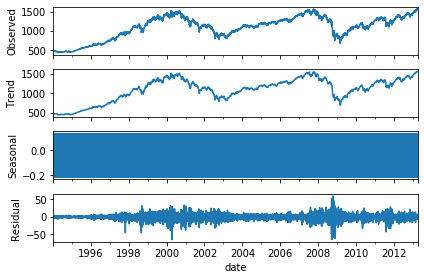

In [23]:
#decomposition example
s_dec_add = seasonal_decompose(data1['market_value'], model='additive')
s_dec_add.plot()
plt.show()

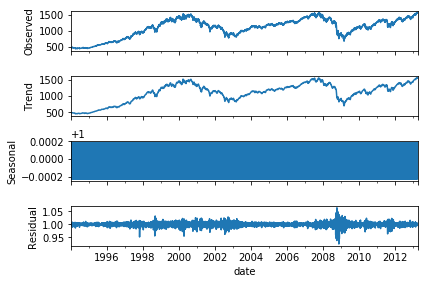

In [24]:
s_dec_mult = seasonal_decompose(data1['market_value'], model='multiplicative')
s_dec_mult.plot()
plt.show()

**Apparently** the results above didnot indicate seasonality for either additive or multiplicative. We know this because the trend pattern closely resembles the series pattern, and the seasonal graph has no seasonal changes, and residuals shows whats left which is the dotcom and recession bubbles


Now ACF and PACF  
- x axis = lags; y axis = correlation coefficient values
- Thin line across the plot at 0 = autocorrelation between the time series and a lagged copy of itself
- blue area = significance. The values outside the blue area are significantly different than 0 which suggests autocorrelation for that specific lag
- the greater the distance in time, the less likely it is that the autocorrelation exists (significance for the lag coefficient decreases) meaning much older values have less to do with today's values

**ACF** relationship between datain current time period and previous time periods (common practice dictates to look back 40 time periods/lags)

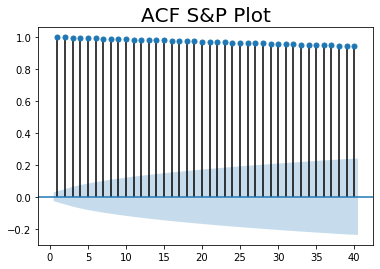

In [25]:
#acF
sgt.plot_acf(data1.market_value, lags=40, zero=False)
plt.title('ACF S&P Plot', size=20)
plt.show()

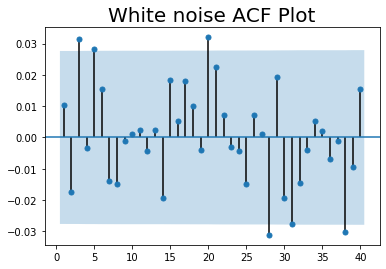

In [26]:
#white noise acf (from the white noise we imported
sgt.plot_acf(data1.wn, lags=40, zero=False)
plt.title('White noise ACF Plot', size=20)
plt.show()
#more values significantly closer to zero and randomly distributed

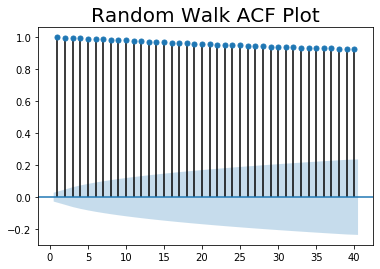

In [27]:
sgt.plot_acf(data1.rw, lags=40, zero=False)
plt.title('Random Walk ACF Plot', size=20)
plt.show()

**PACF** Only the direct relationship that past values have on today's value. Indirect relationship includes how day3 affects day 2 which affects day 1. Direct means isolating how only day 3 affects day 1

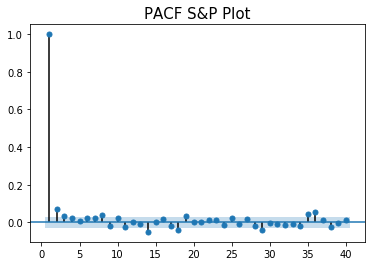

In [28]:
#market value
sgt.plot_pacf(data1.market_value, lags = 40, zero=False, method = 'ols')
plt.title('PACF S&P Plot', size=15)
plt.show()

Most of the values are significant with the PACF graph except for the first one. Most of these are significantly not different from zero => the values attached to them are not important

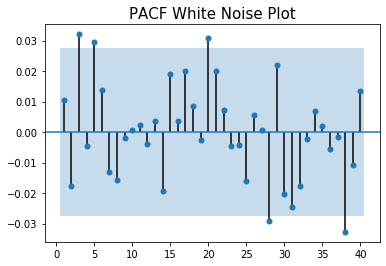

In [29]:
#white noise PACF = there should be no autocorrelation so values should be insignificant
sgt.plot_pacf(data1.wn, lags = 40, zero=False, method = 'ols')
plt.title('PACF White Noise Plot', size=15)
plt.show()

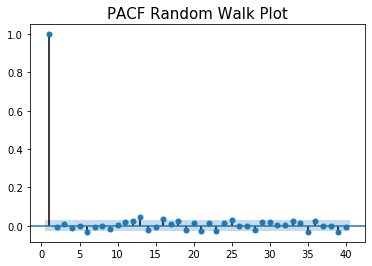

In [30]:
#random walk
#market value
sgt.plot_pacf(data1.rw, lags = 40, zero=False, method = 'ols')
plt.title('PACF Random Walk Plot', size=15)
plt.show()

### Picking the Correct Model
**Need to follow steps/indicators to pick the best approximator**
Start with a simple model and then expand it if it meets several conditions
- The new coefficients for the expanded model need to be significantly different from zero otherwise the estimators for the parameters are essentially zero, hold no predictive power
- We want the model to be parsimonious (Simple as possible) unless the more complex model provides significantly better estimators. To determine this, we use the log-likelihood ratio (LLR) test 

**LLR Test**
- Can only be applied to models with different degrees of freedom (i.e. different # of predictors). We want the model with the higher log likelihood ratio
- We compare the information criteria (IC) of models with the same # of lags. The lower the coefficient, the less data the model requires to make accurate predictions

Two most prominent IC are AIC/BIC. So the model with lower the AIC/BIC is better


**AR Model**
Coefficients of previous time period have to be between 1 and -1. Current period outcome is a function of previous periods outcomes multiplied by a coefficient and an error/residual term. Number of previous periods is determined before making model. As discussed earlier, the less amount of predictors i.e. lagsin this case, the better

In [31]:
#Using ACF and PACF to determine number of lags to include
all_data.asfreq('b')
all_data.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


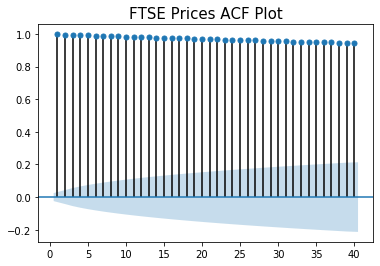

In [32]:
#using FTSE
sgt.plot_acf(all_data.ftse, zero=False, lags=40)
plt.title('FTSE Prices ACF Plot', size=15)
plt.show()

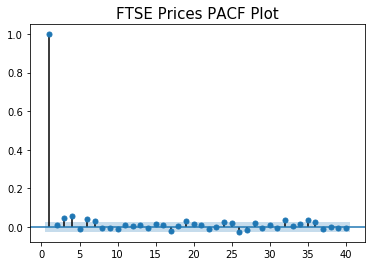

In [33]:
sgt.plot_pacf(all_data.ftse, zero=False, lags=40,method='ols')
plt.title('FTSE Prices PACF Plot', size=15)
plt.show()

we want less than 25 lags, also every 22days, values flip (there are roughly 22 business days in a month). We look mainly at the PACF to select the correct model because it shows the individual effect each past value has on the current one